# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Projects_ThaiPV/eye_blind

/content/drive/MyDrive/Projects_ThaiPV/eye_blind


In [3]:
!ls

data	  Eye_for_blind_Starter_code.ipynb  __pycache__
data.zip  function.py			    unzip.ipynb


In [4]:
#Import all the required libraries

import os
import numpy as np
import cv2
import glob
import imutils
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm
from function import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from collections import Counter
from sklearn.model_selection import train_test_split


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [6]:
#Import the dataset and read the image into a seperate variable
#Count all of Images in folder data/Images
data_dir='data'
all_imgs = glob.glob(data_dir + '/Images/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 4876


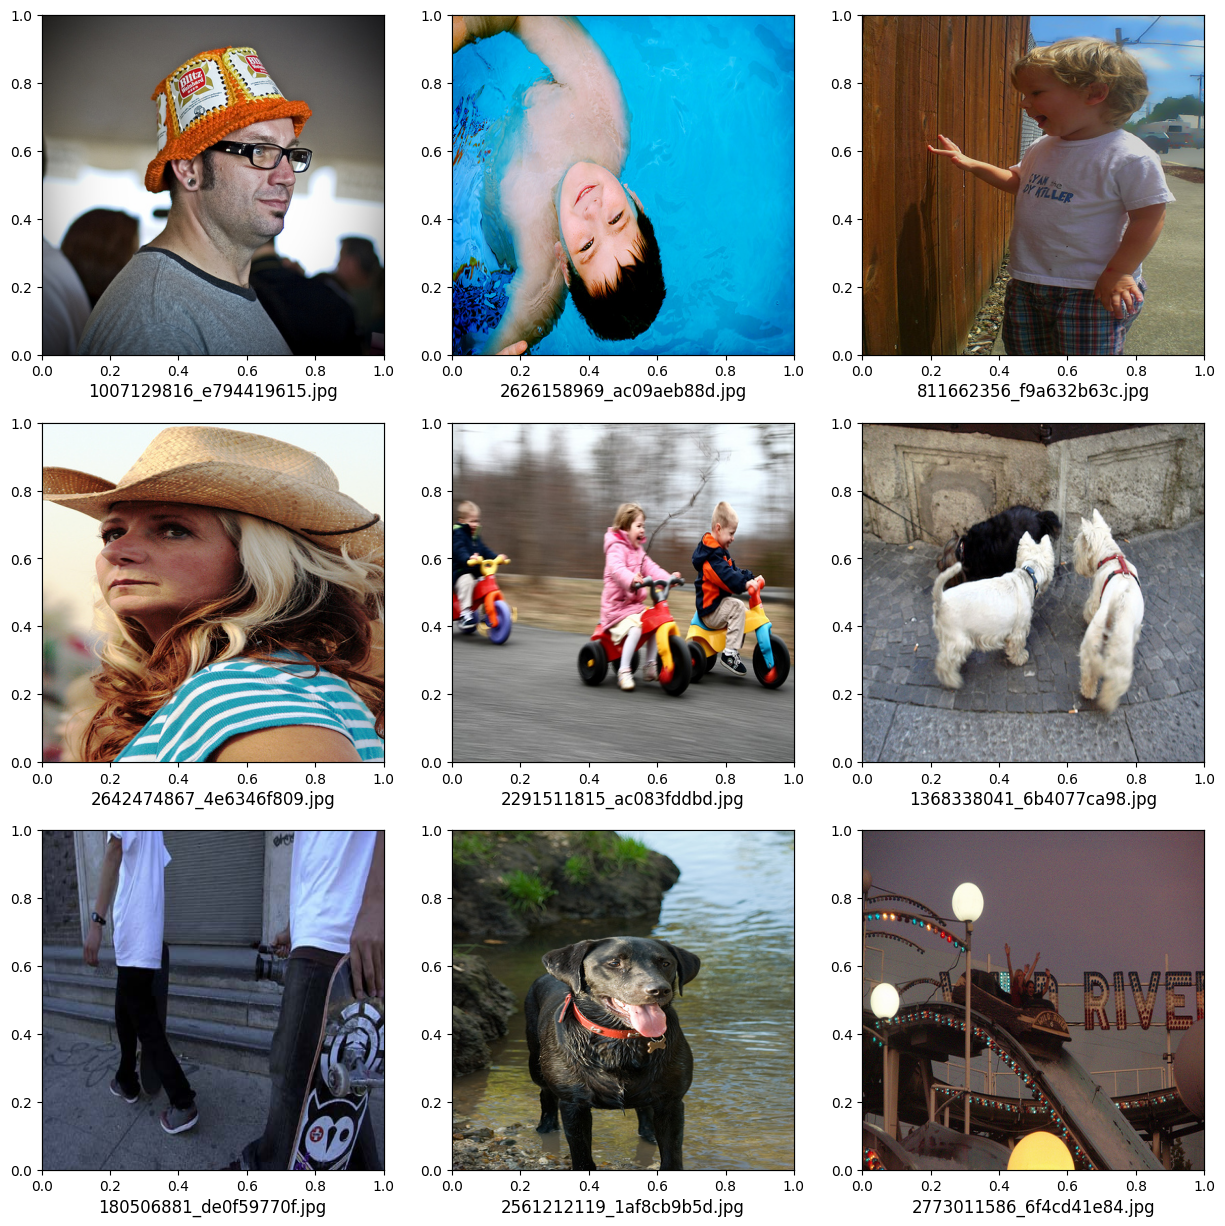

In [7]:
#Visualise both the images in the dataset
show_img(3,3, all_imgs)

In [8]:
#Read Captions in file captions.txt and Convert to Dataframe
def load_doc():
    df_cap = pd.read_csv(data_dir+'/captions.txt', sep = ',')
    return df_cap

df_cap = load_doc()
df_cap.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [8]:
df_cap.info()

In [9]:
# Create new Column with full Path of images
images_path = os.path.abspath(data_dir)+'/Images'
all_img_vector = [images_path+'/'+df_cap['image'][i] for i in range(len(df_cap))]
all_img_vector[:5]

['/content/drive/MyDrive/Projects_ThaiPV/eye_blind/data/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Projects_ThaiPV/eye_blind/data/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Projects_ThaiPV/eye_blind/data/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Projects_ThaiPV/eye_blind/data/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/Projects_ThaiPV/eye_blind/data/Images/1000268201_693b08cb0e.jpg']

In [10]:
df_cap['Path'] = all_img_vector
df_cap.head()

,image,caption,Path
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...


In [11]:
#Modify Columns name
df_cap = df_cap[['image', 'Path', 'caption']]
df_cap = df_cap.rename(columns={'image': 'ID', 'caption': 'Captions'})

df_cap.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,/content/drive/MyDrive/Projects_ThaiPV/eye_bli...,A little girl in a pink dress going into a woo...


In [12]:
#Create a list which contains all the captions
#Mark sentences with <start> and <end> identification during training
df_cap['Captions'] = df_cap['Captions'].apply(lambda x: standardize(x))
df_cap['Captions'][:5]

0    <start> a child in a pink dress is climbing up...
1    <start> a girl going into a wooden building  <...
2    <start> a little girl climbing into a wooden p...
3    <start> a little girl climbing the stairs to h...
4    <start> a little girl in a pink dress going in...
Name: Captions, dtype: object

In [13]:
# Count total of Captions. Each image has 5 caps attached.
print("Total captions present in the dataset: "+ str(len(df_cap['Captions'])))
print("Total images present in the dataset: " + str(len(df_cap['Path'])))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [14]:
#Create the vocabulary & the counter for the captions
vocabulary=[word.lower() for line in df_cap['Captions'] for word in line.split()]
val_count=Counter(vocabulary)
val_count.most_common(32)

[('a', 62986),
 ('<start>', 40455),
 ('<end>', 40455),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265),
 ('of', 6713),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3173),
 ('wearing', 3062),
 ('at', 2914),
 ('people', 2883),
 ('water', 2783),
 ('red', 2672),
 ('young', 2630),
 ('brown', 2563),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2268),
 ('dogs', 2125),
 ('running', 2073)]

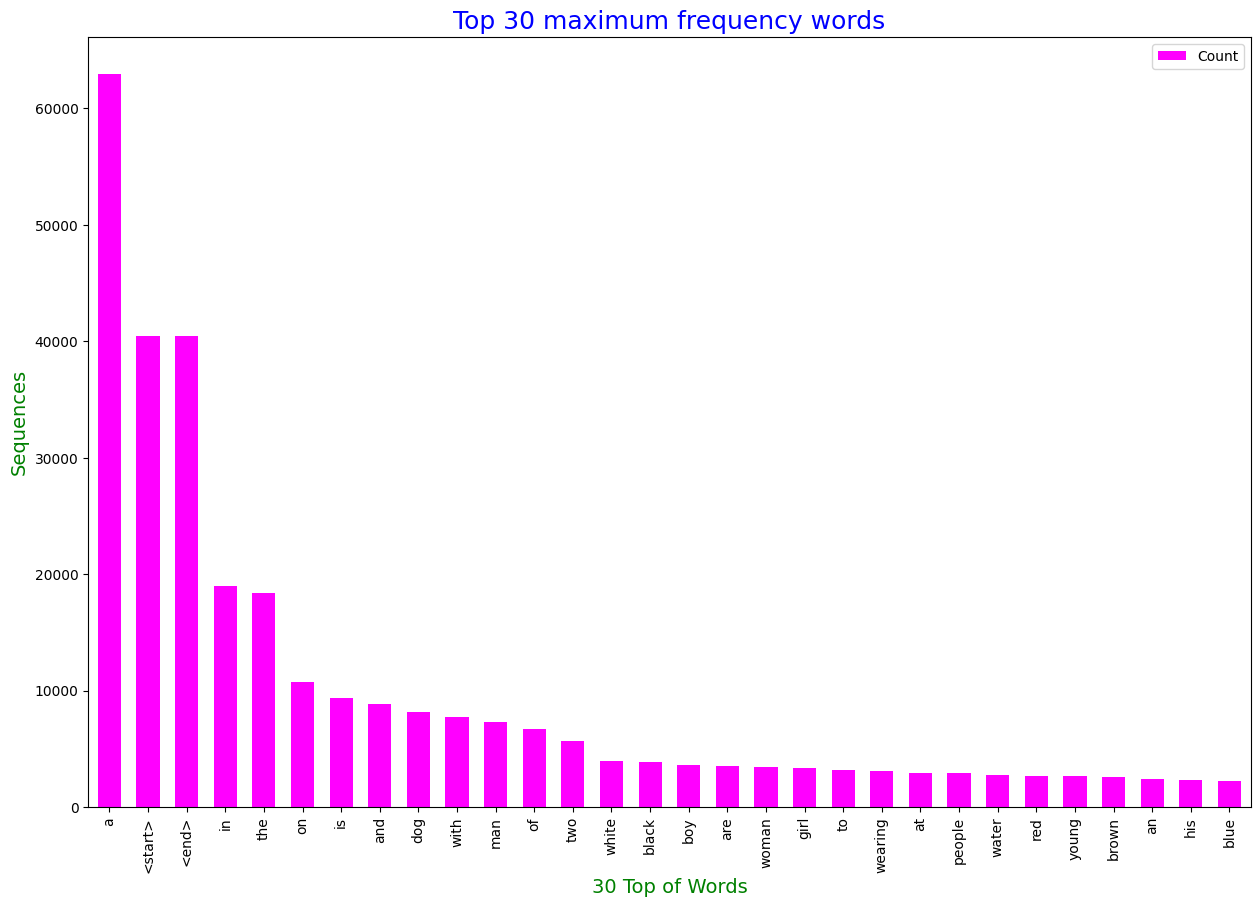

In [15]:
#Visualise the top 32 occuring words in the captions include <start> and <end>

most_top_word(val_count, ntop=32)

In [16]:
# Show captions and Image
# show_img_desc(df_cap)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [17]:
# create the tokenizer
# "OOV" stands for "Out-Of-Vocabulary," referring to words that are not present in the vocabulary or training data. Values of OVV = 'UNK' (unknown)
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False, 
                      oov_token = 'UNK')
tokenizer.index_docs

defaultdict(int, {})

In [18]:
tokenizer.index_word

{}

In [19]:
# Fit captions in df_cap to tokenizer and test values of text after fit text
tokenizer.fit_on_texts(df_cap['Captions'])

#transform each text into a sequence of integers
text_to_cvt = ['a wide river with many small waterfalls',
               'a sled dog pulling a blue toy excavator in the snow']
print(tokenizer.texts_to_sequences(text_to_cvt))

[[2, 679, 227, 11, 268, 53, 2559], [2, 375, 10, 392, 2, 31, 105, 1, 5, 6, 45]]


In [20]:
train_seqs = tokenizer.texts_to_sequences(df_cap['Captions'])
train_seqs[:5]

[[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4],
 [3, 2, 20, 315, 65, 2, 195, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 195, 2432, 4],
 [3, 2, 41, 20, 120, 6, 393, 21, 61, 2432, 4],
 [3, 2, 41, 20, 5, 2, 91, 171, 315, 65, 2, 195, 2995, 4]]

In [ ]:
# ## Note##
# - Start value =3 and end value = 4. This is ID of <start> and <end>
# - Let see in line below

In [21]:
# Get the top 10 key-value pairs
top_10 = {k: tokenizer.index_word[k] for k in list(tokenizer.index_word.keys())[:10]}
top_10

{1: 'UNK',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and',
 10: 'dog'}

In [22]:
# Crate PAD with index = 0
# In Tokenizer: Normalize the string length by adding PAD to equal the overall length of a sentence
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

tokenizer.index_word = dict(sorted(tokenizer.index_word.items()))

# Get the top 10 key-value pairs
top_10 = {k: tokenizer.index_word[k] for k in list(tokenizer.index_word.keys())[:10]}
top_10

{0: 'PAD',
 1: 'UNK',
 2: 'a',
 3: '<start>',
 4: '<end>',
 5: 'in',
 6: 'the',
 7: 'on',
 8: 'is',
 9: 'and'}

In [23]:
# Check created PAD
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [24]:
# Create a word count of your tokenizer to visulize
# the Top 32 occuring words after text processing include <start> and <end>
tokenizer_top_words = [word for line in df_cap['Captions'] for word in line.split() ]

# Tokenizer_top_words_count
tokenizer_top_words_count = Counter(tokenizer_top_words)
tokenizer_top_words_count.most_common(32)

[('a', 62986),
 ('<start>', 40455),
 ('<end>', 40455),
 ('in', 18974),
 ('the', 18418),
 ('on', 10743),
 ('is', 9345),
 ('and', 8851),
 ('dog', 8136),
 ('with', 7765),
 ('man', 7265),
 ('of', 6713),
 ('two', 5638),
 ('white', 3940),
 ('black', 3832),
 ('boy', 3581),
 ('are', 3504),
 ('woman', 3402),
 ('girl', 3328),
 ('to', 3173),
 ('wearing', 3062),
 ('at', 2914),
 ('people', 2883),
 ('water', 2783),
 ('red', 2672),
 ('young', 2630),
 ('brown', 2563),
 ('an', 2432),
 ('his', 2357),
 ('blue', 2268)]

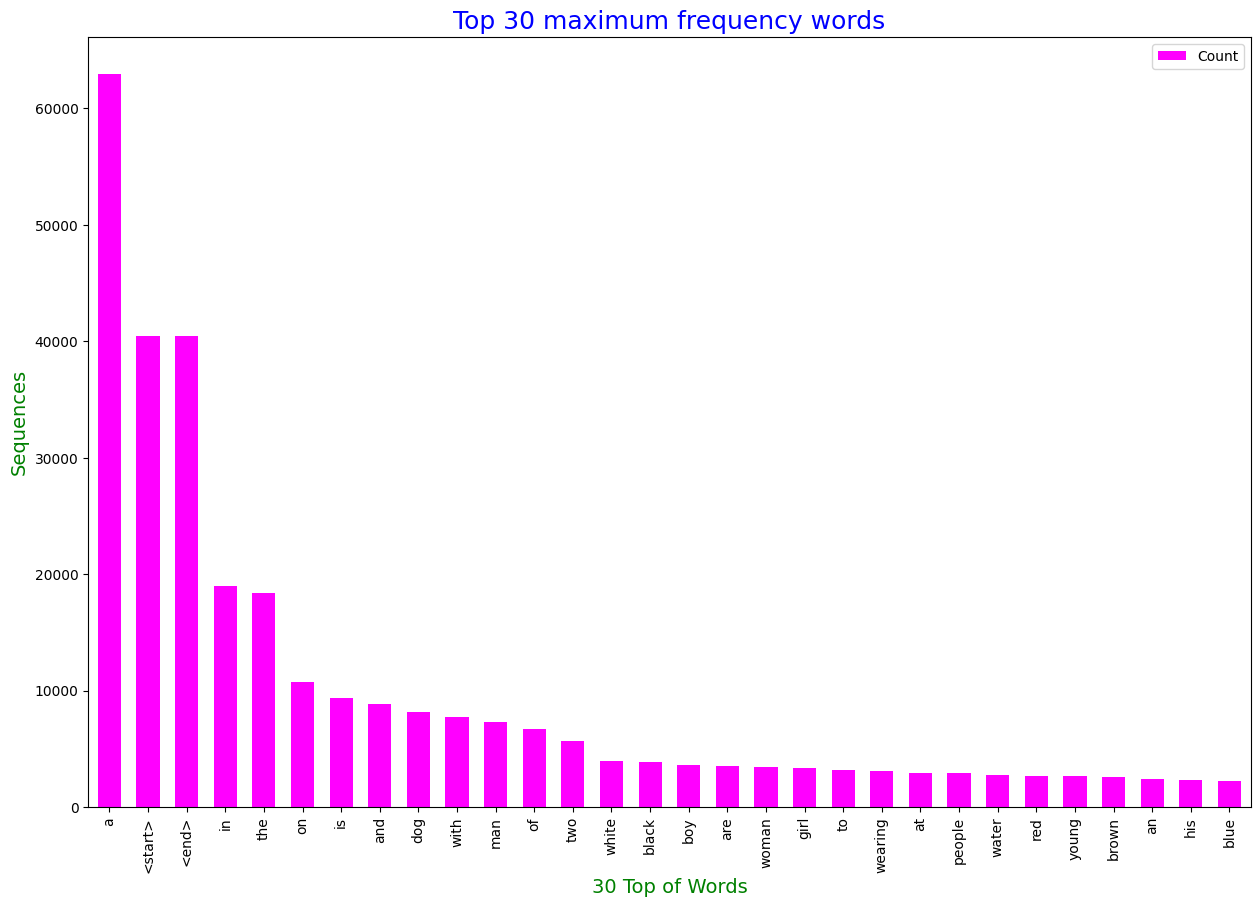

In [25]:
most_top_word(tokenizer_top_words_count, ntop=32)

In [26]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]
longest_word_length = max(train_seqs_len)
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs,
                                                          padding= 'post',
                                                          maxlen = longest_word_length,
                                                          dtype='int32',
                                                          value=0)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 38)


In [27]:
# Check caption, token and vector-caption
print(df_cap['Captions'][0])
print(train_seqs[0])
print(cap_vector[0])

<start> a child in a pink dress is climbing up a set of stairs in an entry way  <end>
[3, 2, 43, 5, 2, 91, 171, 8, 120, 54, 2, 396, 13, 393, 5, 29, 1, 694, 4]
[  3   2  43   5   2  91 171   8 120  54   2 396  13 393   5  29   1 694
   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


## Now, Pre-processing the images and Use Pretrain network 

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


In [29]:
# Load inceptionV3 with no softmax layer
# Create load_image to read image and image processing to the correct input standard of the InceptionV3 network
inception_model = InceptionV3(weights='imagenet', include_top=False)

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = preprocess_input(image)
    image = tf.expand_dims(image, axis=0)
    return image, image_path

# Create function to extract features from load_image function with a BATCH
@tf.function
def get_image_features(images):
    features = tf.map_fn(lambda x: inception_model(x, training=False), images)
    return features

KeyboardInterrupt: ignored

In [ ]:
# Test load_image function
img_path = 'data/Images/10815824_2997e03d76.jpg'
features_test, _ = load_image(img_path)
print(features_test.shape)

In [ ]:
# Now, Get unique values in df_cap['Path']
# to compare the following features. because there are 5*8091 captions, 
# Can't load that much image will cause memory loss. 
# The solution is to load each image once and map it to an features based on the image name

img_proc_list = tf.data.Dataset.from_tensor_slices(df_cap['Path'].unique())
img_proc_list = img_proc_list.map(load_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)

img_proc_list = img_proc_list.batch(16, drop_remainder=False)
img_proc_list

In [ ]:
# Test a batch
batchIMG, pathDir = next(iter(img_proc_list))
pathDir

In [ ]:
feature_path = pathDir[0].numpy().decode('utf-8')
feature_path

In [ ]:
batchIMG[0]

In [ ]:
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)

for ax, image in zip(axes, batchIMG[0:6]) :
    print('Shape after resize : ', image.shape)
    ax.imshow(image[0])

In [ ]:
# Create train-test based on Path and Caption-vector has created before
path_train, path_test, cap_train, cap_test = train_test_split(df_cap['Path'].to_numpy(),
                                                              cap_vector,
                                                              test_size=0.2,
                                                              random_state=101)

In [ ]:
path_test.shape, path_test[0]

In [ ]:
cap_test.shape, cap_test[0]

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

In [ ]:
# After Create all of Unique image from Path, I get features each of image processing
img_features = {}
progress_bar = tqdm(img_proc_list, dynamic_ncols=True)
for idx, (image, image_path) in enumerate(progress_bar):
    batch_features = get_image_features(image)
    batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[-1]))
    progress_bar.set_description(f"Processing item: {idx}")
                                     
    for batch_feat, path in zip(batch_features, image_path) :
        feature_path = path.numpy().decode('utf-8')
        img_features[feature_path] = batch_feat

In [ ]:
len(img_features)

In [ ]:
batch_features.shape

In [ ]:
# Show Image Features
for i in list(img_features.keys())[:2]:
    print(i)
    print(img_features[i])
    print('=========')

In [ ]:
# As previous instructions, the function below will perform feature mapping based on the image path
def image_feature_map(imagePath, caption):
    try:
        feature_tensor = img_features[imagePath.decode('utf-8')]
    except:
        feature_tensor = img_features[imagePath]
    return feature_tensor, caption

In [ ]:
# Check if the data has not been tampered
imagePath = df_cap['Path'][100]
caption_test = df_cap['Captions'][100]

In [ ]:
print(image_feature_map(imagePath, caption_test))

In [ ]:

get = inception_model(load_image(imagePath)[0], training=False)
get = tf.reshape(get, (get.shape[0], -1, batch_features.shape[-1]))
get[0]

In [ ]:
- Mapping was successful

In [ ]:
# With train-test created before, defined gen_dataset function to mapping all captions with features
BUFFER_SIZE = 1000
BATCH_SIZE = 16

def gen_dataset(img, capt):
    data = tf.data.Dataset.from_tensor_slices((img, capt))
    
    data = data.map(lambda val1, val2 : tf.numpy_function(image_feature_map, [val1, val2], [tf.float32, tf.int32]))
    data = data.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
    data = data.batch(BATCH_SIZE, drop_remainder=False)
    data = data.prefetch(tf.data.experimental.AUTOTUNE)

    return data

In [ ]:
train_dataset = gen_dataset(path_train, cap_train)
test_dataset = gen_dataset(path_test, cap_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)
print(sample_cap_batch.shape)

In [ ]:
train_dataset_size = tf.data.experimental.cardinality(train_dataset).numpy()
print("Train dataset size:", train_dataset_size, f"(~= {path_train.shape[0]/BATCH_SIZE})")

test_dataset_size = tf.data.experimental.cardinality(test_dataset).numpy()
print("Test dataset size:", test_dataset_size, f"(~= {path_test.shape[0]/BATCH_SIZE})")

In [ ]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

### Encoder

In [ ]:
embedding_dim = 256 
units = 512

vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

max_length = longest_word_length
feature_shape = 2048
attention_feature_shape = 16 # shape features output of InceptionV3

In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        features =  self.dense(features)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

### Attention model

In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]

        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))  

        # extract your attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1) 

        #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features 

        # reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)  
        
        return context_vector, attention_weights

### Decoder

In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output, state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder=Encoder(embedding_dim)

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape
    
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_path = "eye_blind/ckpt"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        encoder_op = encoder(img_tensor)

        predictions, _, _ = decoder(dec_input, encoder_op, hidden)
        for t in range(1, target.shape[1]):
            loss += loss_function(target[:, t], predictions)
            predictions, _, _ = decoder(target[:, t], encoder_op, hidden)
        
    avg_loss = loss / int(target.shape[1])
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    encoder_op = encoder(img_tensor)
    predictions, _, _ = decoder(dec_input, encoder_op, hidden)
    
    for t in range(1, target.shape[1]):
        loss += loss_function(target[:, t], predictions)
        predictions, _, _ = decoder(target[:, t], encoder_op, hidden)

    avg_loss = loss / int(target.shape[1])
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return loss, avg_loss


In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    test_num_steps = len(test_dataset)

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss

    avg_test_loss = total_loss / test_num_steps
    return avg_test_loss


In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

In [ ]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = #extract the predicted id(embedded value) which carries the max value
        #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [ ]:
def beam_evaluate(image, beam_index = #your value for beam index):

    #write your code to evaluate the result using beam search
                  
    return final_caption



In [ ]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
rid = np.random.randint(0, len(img_test))
test_image = img_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=#set your weights)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)